## Understanding QA
A QA or reading comprehension task comprises a set of reading comprehension texts
with respective questions on them. An exemplary dataset from this scope is SQUAD or
Stanford Question Answering Dataset. This dataset consists of Wikipedia texts and
respective questions asked about them. The answers are in the form of segments of the
original Wikipedia text.

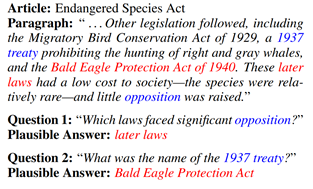

In [1]:
from pprint import pprint
from datasets import load_dataset
squad = load_dataset('squad')
for item in squad["train"][1].items():
    print(item[0])
    pprint(item[1])
    print("="*20)

Extracting data files: 100%|█████████████████████| 2/2 [00:00<00:00, 764.90it/s]


Dataset squad downloaded and prepared to /home/nitiz/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 427.03it/s]

id
'5733be284776f4190066117f'
title
'University_of_Notre_Dame'
context
('Architecturally, the school has a Catholic character. Atop the Main '
 "Building's gold dome is a golden statue of the Virgin Mary. Immediately in "
 'front of the Main Building and facing it, is a copper statue of Christ with '
 'arms upraised with the legend "Venite Ad Me Omnes". Next to the Main '
 'Building is the Basilica of the Sacred Heart. Immediately behind the '
 'basilica is the Grotto, a Marian place of prayer and reflection. It is a '
 'replica of the grotto at Lourdes, France where the Virgin Mary reputedly '
 'appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive '
 '(and in a direct line that connects through 3 statues and the Gold Dome), is '
 'a simple, modern stone statue of Mary.')
question
'What is in front of the Notre Dame Main Building?'
answers
{'answer_start': [188], 'text': ['a copper statue of Christ']}


In [2]:
from datasets import load_dataset
squad = load_dataset('squad_v2')

Extracting data files: 100%|████████████████████| 2/2 [00:00<00:00, 1856.30it/s]


Dataset squad_v2 downloaded and prepared to /home/nitiz/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d. Subsequent calls will reuse this data.


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 622.85it/s]


In [3]:
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

In [4]:
from transformers import AutoTokenizer
model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)


In [5]:
max_length = 384
doc_stride = 128
example = squad["train"][173]
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens= True,
    stride = doc_stride
)

In [8]:
len(tokenized_example['input_ids'])

2

In [9]:
for input_ids in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(input_ids))
    print("-"*50)

2023-06-02 18:13:11.405086: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-02 18:13:11.580452: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-02 18:13:11.581462: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 18:13:12.899146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[CLS] beyonce got married in 2008 to whom? [SEP] on april 4, 2008, beyonce married jay z. she publicly revealed their marriage in a video montage at the listening party for her third studio album, i am... sasha fierce, in manhattan's sony club on october 22, 2008. i am... sasha fierce was released on november 18, 2008 in the united states. the album formally introduces beyonce's alter ego sasha fierce, conceived during the making of her 2003 single " crazy in love ", selling 482, 000 copies in its first week, debuting atop the billboard 200, and giving beyonce her third consecutive number - one album in the us. the album featured the number - one song " single ladies ( put a ring on it ) " and the top - five songs " if i were a boy " and " halo ". achieving the accomplishment of becoming her longest - running hot 100 single in her career, " halo "'s success in the us helped beyonce attain more top - ten singles on the list than any other woman during the 2000s. it also included the suc

In [18]:

def prepare_train_features(examples, pad_on_right=True): 
    tokenized_examples = tokenizer( 
        examples["question" if pad_on_right else "context"], 
        examples["context" if pad_on_right else "question"], 
        truncation="only_second" if pad_on_right else "only_first", 
        max_length=max_length, 
        stride=doc_stride, 
        return_overflowing_tokens=True, 
        return_offsets_mapping=True, 
        padding="max_length", 
    ) 
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping") 
    offset_mapping = tokenized_examples.pop("offset_mapping") 
    tokenized_examples["start_positions"] = [] 
    tokenized_examples["end_positions"] = [] 
    for i, offsets in enumerate(offset_mapping): 
        input_ids = tokenized_examples["input_ids"][i] 
        cls_index = input_ids.index(tokenizer.cls_token_id) 
        sequence_ids = tokenized_examples.sequence_ids(i) 
        sample_index = sample_mapping[i] 
        answers = examples["answers"][sample_index] 
        if len(answers["answer_start"]) == 0: 
            tokenized_examples["start_positions"].append(cls_index) 
            tokenized_examples["end_positions"].append(cls_index) 
        else: 
            start_char = answers["answer_start"][0] 
            end_char = start_char + len(answers["text"][0]) 
            token_start_index = 0 
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0): 
                token_start_index += 1 
            token_end_index = len(input_ids) - 1 
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0): 
                token_end_index -= 1 
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char): 
                tokenized_examples["start_positions"].append(cls_index) 
                tokenized_examples["end_positions"].append(cls_index) 
            else: 
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char: 
                    token_start_index += 1 
                tokenized_examples["start_positions"].append(token_start_index - 1) 
                while offsets[token_end_index][1] >= end_char: 
                    token_end_index -= 1 
                tokenized_examples["end_positions"].append(token_end_index + 1) 
    return tokenized_examples 
     

In [19]:
tokenized_datasets = squad.map(prepare_train_features, batched=True, remove_columns=squad["train"].column_names)


In [20]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer 
model = AutoModelForQuestionAnswering.from_pretrained(model)      

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

In [25]:
args = TrainingArguments( 
    f"test-squad", 
    evaluation_strategy = "epoch", 
    learning_rate=2e-3, 
    per_device_train_batch_size=16, 
    per_device_eval_batch_size=16, 
    num_train_epochs=2, 
    weight_decay=0.01, 
)
     

from transformers import default_data_collator 
data_collator = default_data_collator 
     

trainer = Trainer( 
    model, 
    args, 
    train_dataset=tokenized_datasets["train"], 
    eval_dataset=tokenized_datasets["validation"], 
    data_collator=data_collator, 
    tokenizer=tokenizer, 
) 

In [26]:
trainer.train() 

OutOfMemoryError: CUDA out of memory. Tried to allocate 108.00 MiB (GPU 0; 5.80 GiB total capacity; 4.73 GiB already allocated; 69.44 MiB free; 4.84 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
trainer.save_model("distillBERT_SQUAD")

In [ ]:
from transformers import pipeline
qa_model = pipeline('question-answering', model='distilbert-base-cased-distilled-squad', tokenizer='distilbert-base-cased') 


In [ ]:
question = squad["validation"][0]["question"] 
context = squad["validation"][0]["context"] 
print("Question:") 
print(question) 
print("Context:") 
print(context) 

In [ ]:
qa_model(question=question, context=context) 
